<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-необходимых-для-решения-библиотек" data-toc-modified-id="Загрузка-необходимых-для-решения-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка необходимых для решения библиотек</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-данных-на-выборки" data-toc-modified-id="Разделение-данных-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение данных на выборки</a></span></li><li><span><a href="#Обучение-RandomForest" data-toc-modified-id="Обучение-RandomForest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение RandomForest</a></span></li><li><span><a href="#Обучение-LightGBM" data-toc-modified-id="Обучение-LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение LightGBM</a></span></li><li><span><a href="#Обучение-CatBost" data-toc-modified-id="Обучение-CatBost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обучение CatBost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Загрузка необходимых для решения библиотек

In [1]:
# для работы с таблицами
import pandas as pd
# для работы с массивами данных
import numpy as np 
# для разделения таблицы на выборки
from sklearn.model_selection import train_test_split
# для использования модели случайного леса
from sklearn.ensemble import RandomForestRegressor
# для автоматического подбора параметров модели
from sklearn.model_selection import GridSearchCV
# для расчета среднеквадратичной ошибки
from sklearn.metrics import mean_squared_error
# для использования модели CatBoost и подготовки данных
from catboost import CatBoostRegressor, Pool
# для исползования модели lightgbm
import lightgbm as lgb
# для построения графиков
import matplotlib.pyplot as plt
# для разложения временного ряда на три составляющие: тренд, сезонность и остаток
from statsmodels.tsa.seasonal import seasonal_decompose
# для кросс-валидации временных рядов
from sklearn.model_selection import TimeSeriesSplit
# для работы с временем
import time

### Подготовка данных

Загрузим данные:

In [2]:
# parse_dates преобразует object в формат даты, index_col делает столбец индексом
frame = pd.read_csv('/datasets/taxi.csv', parse_dates =[0], index_col= 0)

Оценим информацию о данных:

In [3]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем данные по возрастанию индекса:

In [4]:
frame = frame.sort_index()

Убедимся, что данные возрастают монотонно (в хронологическом ли порядке расположены даты и время):

In [5]:
frame.index.is_monotonic

True

Оценим содержание таблицы:

In [6]:
frame.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В рассматриваемой таблице данные предоставлены с периодичностью в 10 минут. Согласно заданию, данные необходимо ресемплировать с периодичностью в 1 час:

In [7]:
#ресемлируем данные по столбцу-индексу datetime с периодичностью в 1 час, просуммируем количество заказов для кажого часа
frame = frame.resample("1H").sum()

Создадим переменную для сравнения стационарности выборок: исходная или полученной путем разности рядов:

In [8]:
frame_new = frame.copy()

Создадим переменную для создания корректных признаков признаков:

In [9]:
final_frame = frame.copy()

Добавим к таблице скользящее среднее значений и скользящее стандартное отклонение:

In [10]:
frame["rolling_mean"] = frame["num_orders"].rolling(20).mean()
frame["rolling_std"] = frame["num_orders"].rolling(20).std()

Метод работает так: экспериментально подбирается размер окна — интервал, в котором выполняют усреднение. Чем интервал больше, тем сильнее сглаживание. Затем окно начинает «скользить» почти от начала ряда к его концу, в каждой точке вычисляя среднее значение ряда и тем самым сглаживая его.

Отобразим новую таблицу:

In [11]:
frame.tail()

,num_orders,rolling_mean,rolling_std
datetime,,,
2018-08-31 19:00:00,136,163.85,66.478548
2018-08-31 20:00:00,154,157.75,61.019302
2018-08-31 21:00:00,159,156.00,60.423941
2018-08-31 22:00:00,223,155.65,59.991469
2018-08-31 23:00:00,205,160.95,59.402707


__Вывод:__  
Данные подготовлены к анализу.

## Анализ

* Оценим распределение данных на графике:

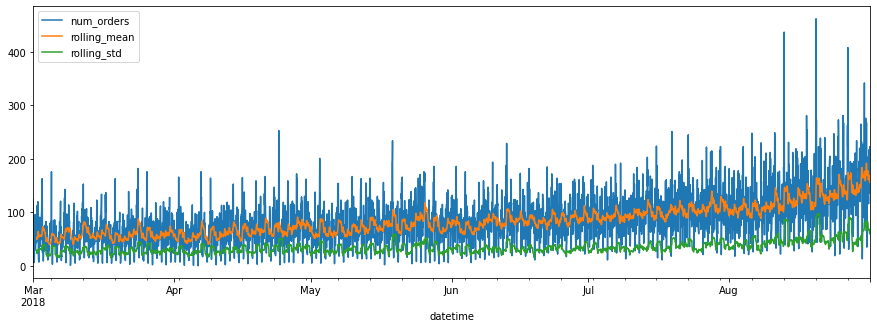

In [12]:
frame.plot(figsize=(15,5));

Временной ряд на графике сложно назвать стационарным, так как у него явно меняется среднее значение. При этом, оценить изменение стандартного отклоления достаточно сложно. 

Чтобы ряд сделать более стационарным, найдём разности его значений.  
Разности временного ряда — это набор разностей между соседними элементами временного ряда, т.е. из каждого значения вычитается предыдущее:

In [13]:
frame_new = frame - frame.shift()
frame_new["rolling_mean"] = frame_new["num_orders"].rolling(20).mean()
frame_new["rolling_std"] = frame_new["num_orders"].rolling(20).std()

Оценим распределение данных на графике разностей:

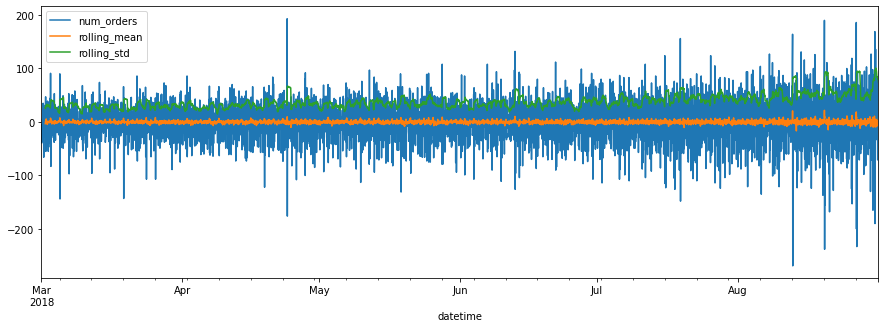

In [14]:
frame_new.plot(figsize=(15,5));

Исходя из информации на новом графике, данный ряд больше подходит под критерий стационарного ряда и принимается таковым для дальнейшей работы.

* Создадим новые признаки:

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
make_features(final_frame,24,20)

In [17]:
final_frame.head(10)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,2018,3,1,3,15.0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Построим графики тренда и сезонности:

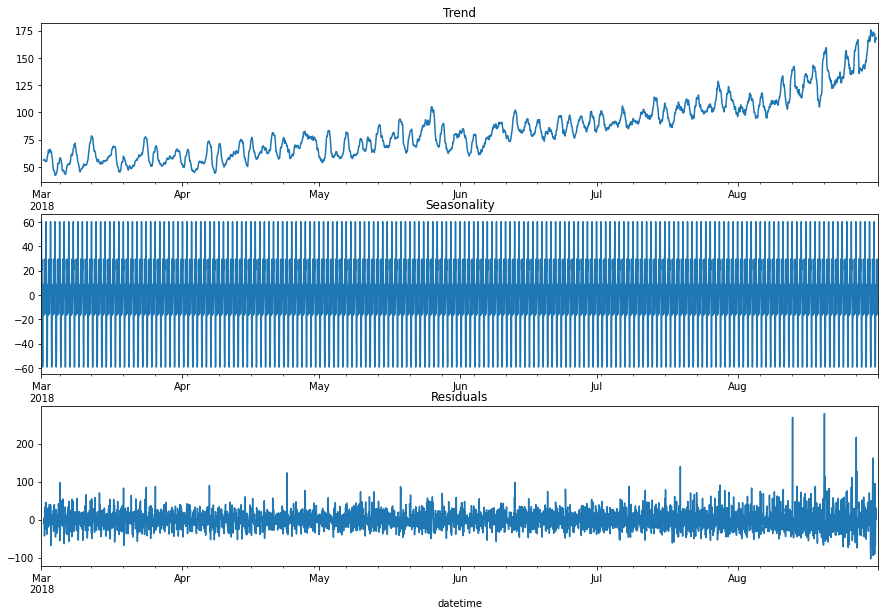

In [18]:
decomposed = seasonal_decompose(final_frame["num_orders"])
fig,ax = plt.subplots(3,1,figsize = (15,10))

decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals');

Дисперсия ряда со временем увеличивается.  
По тренду видно, что со временем все больше и больше людей пользуется услугой заказа такси.

* Рассмотрим сезонность на небольшом временном промежутке:

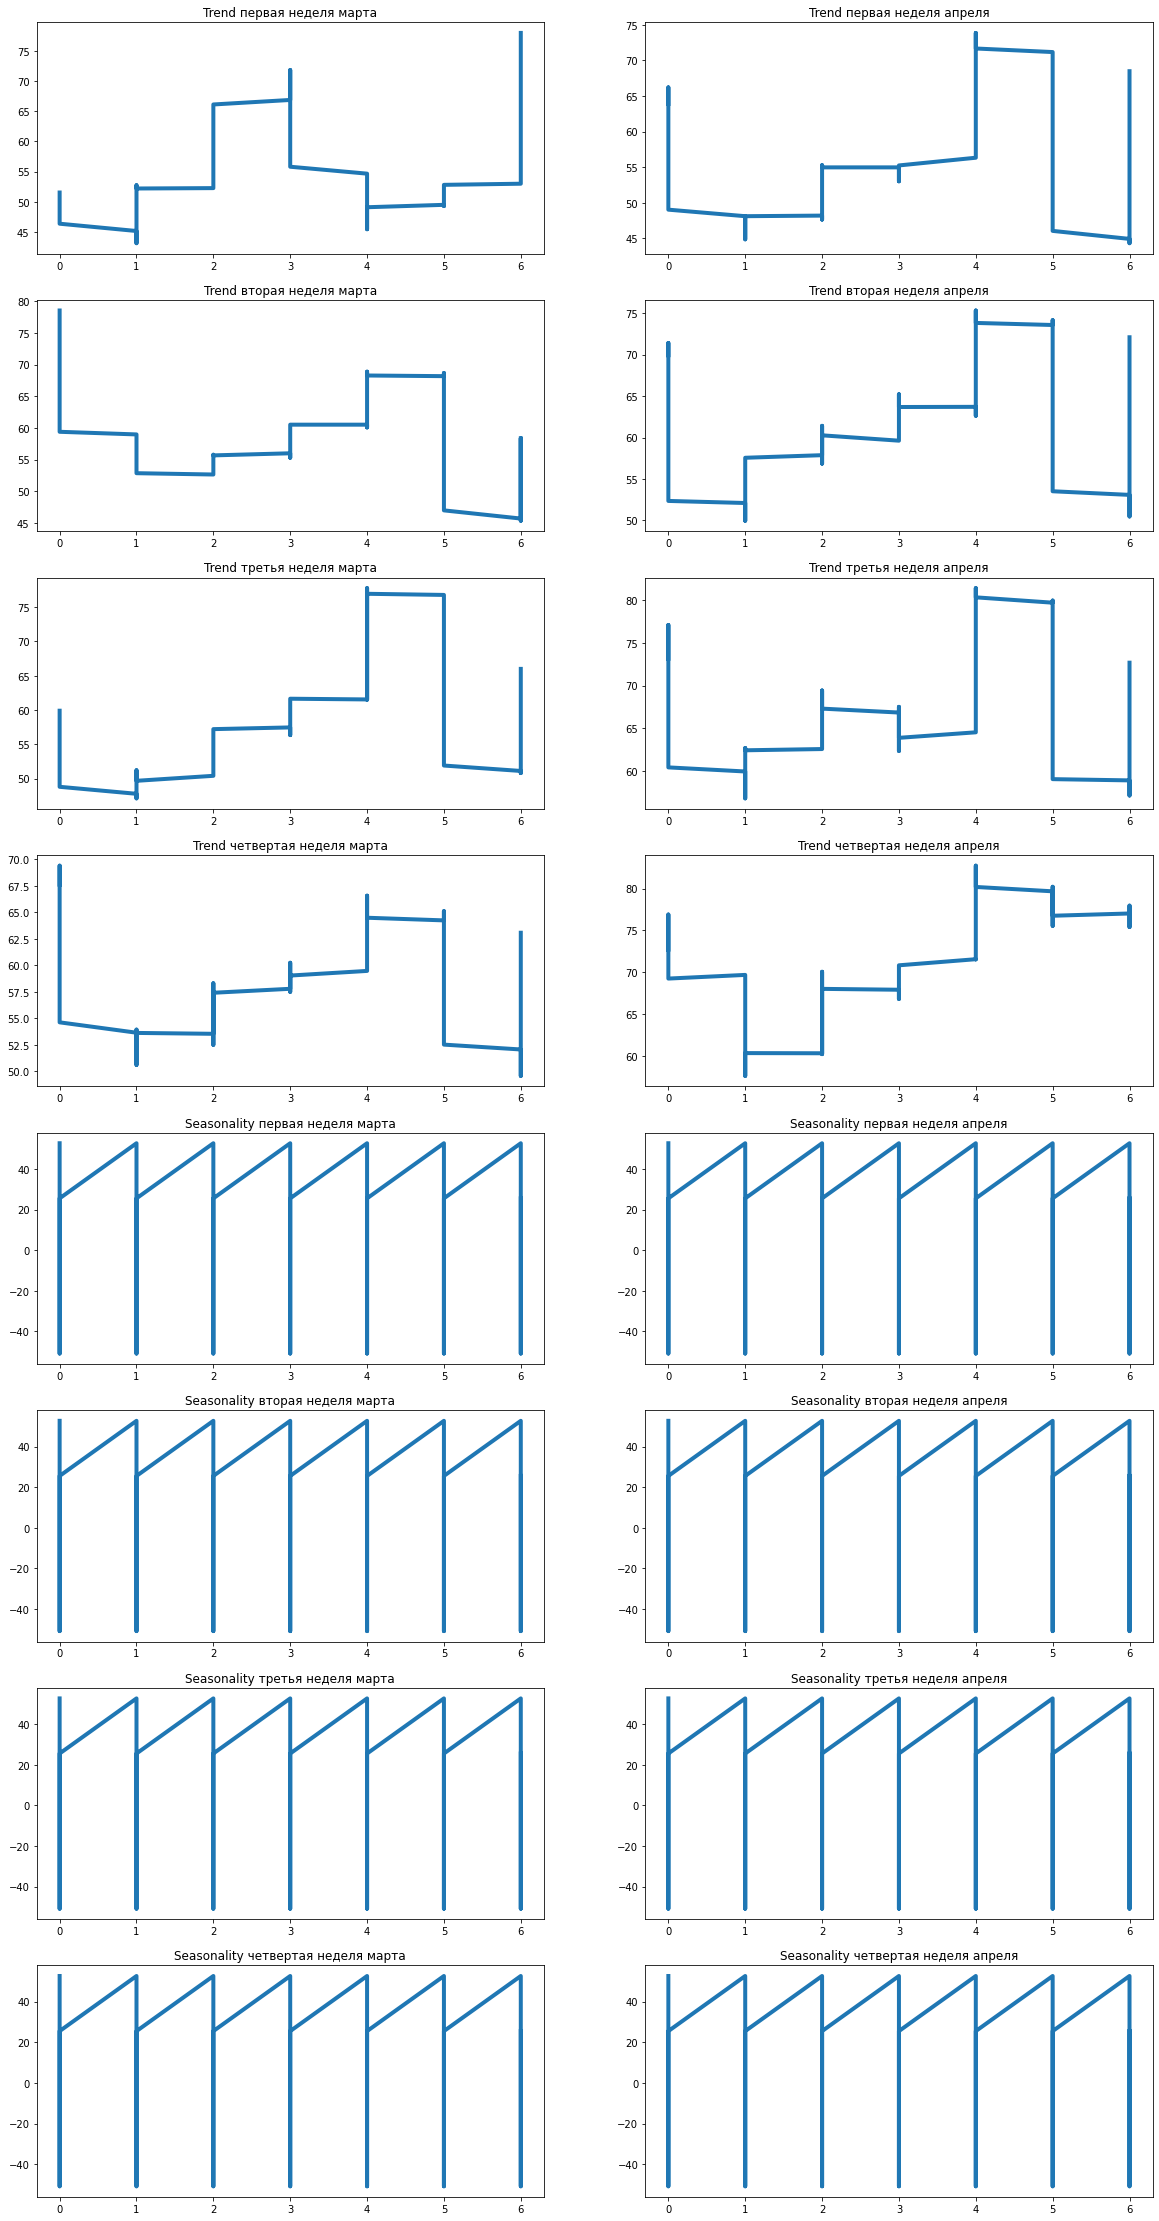

In [19]:
decomposed_short = seasonal_decompose(final_frame["2018-03-05":"2018-04-29"]["num_orders"])
fig2,ax2 = plt.subplots(8,2,figsize = (20,40))

# Trend

# Март
ax2[0][0].plot(decomposed_short.trend["2018-03-05":"2018-03-11"].index.dayofweek,
            decomposed_short.trend["2018-03-05":"2018-03-11"].values,linewidth=4)
ax2[0][0].set_title("Trend первая неделя марта")

ax2[1][0].plot(decomposed_short.trend["2018-03-12":"2018-03-18"].index.dayofweek,
            decomposed_short.trend["2018-03-12":"2018-03-18"].values,linewidth=4)
ax2[1][0].set_title("Trend вторая неделя марта")

ax2[2][0].plot(decomposed_short.trend["2018-03-19":"2018-03-25"].index.dayofweek,
            decomposed_short.trend["2018-03-19":"2018-03-25"].values,linewidth=4)
ax2[2][0].set_title("Trend третья неделя марта")

ax2[3][0].plot(decomposed_short.trend["2018-03-26":"2018-04-01"].index.dayofweek,
            decomposed_short.trend["2018-03-26":"2018-04-01"].values,linewidth=4)
ax2[3][0].set_title("Trend четвертая неделя марта")

# Апрель
ax2[0][1].plot(decomposed_short.trend["2018-04-02":"2018-04-08"].index.dayofweek,
            decomposed_short.trend["2018-04-02":"2018-04-08"].values,linewidth=4)
ax2[0][1].set_title("Trend первая неделя апреля")

ax2[1][1].plot(decomposed_short.trend["2018-04-09":"2018-04-15"].index.dayofweek,
            decomposed_short.trend["2018-04-09":"2018-04-15"].values,linewidth=4)
ax2[1][1].set_title("Trend вторая неделя апреля")

ax2[2][1].plot(decomposed_short.trend["2018-04-16":"2018-04-22"].index.dayofweek,
            decomposed_short.trend["2018-04-16":"2018-04-22"].values,linewidth= 4)
ax2[2][1].set_title("Trend третья неделя апреля")

ax2[3][1].plot(decomposed_short.trend["2018-04-23":"2018-04-29"].index.dayofweek,
            decomposed_short.trend["2018-04-23":"2018-04-29"].values,linewidth= 4)
ax2[3][1].set_title("Trend четвертая неделя апреля")

# Seasonality

# Март
ax2[4][0].plot(decomposed_short.seasonal["2018-03-05":"2018-03-11"].index.dayofweek,
            decomposed_short.seasonal["2018-03-05":"2018-03-11"].values,linewidth=4)
ax2[4][0].set_title("Seasonality первая неделя марта")

ax2[5][0].plot(decomposed_short.seasonal["2018-03-12":"2018-03-18"].index.dayofweek,
            decomposed_short.seasonal["2018-03-12":"2018-03-18"].values,linewidth=4)
ax2[5][0].set_title("Seasonality вторая неделя марта")

ax2[6][0].plot(decomposed_short.seasonal["2018-03-19":"2018-03-25"].index.dayofweek,
            decomposed_short.seasonal["2018-03-19":"2018-03-25"].values,linewidth=4)
ax2[6][0].set_title("Seasonality третья неделя марта")

ax2[7][0].plot(decomposed_short.seasonal["2018-03-26":"2018-04-01"].index.dayofweek,
            decomposed_short.seasonal["2018-03-26":"2018-04-01"].values,linewidth=4)
ax2[7][0].set_title("Seasonality четвертая неделя марта")

# Апрель
ax2[4][1].plot(decomposed_short.seasonal["2018-04-02":"2018-04-08"].index.dayofweek,
            decomposed_short.seasonal["2018-04-02":"2018-04-08"].values,linewidth=4)
ax2[4][1].set_title("Seasonality первая неделя апреля")

ax2[5][1].plot(decomposed_short.seasonal["2018-04-09":"2018-04-15"].index.dayofweek,
            decomposed_short.seasonal["2018-04-09":"2018-04-15"].values,linewidth=4)
ax2[5][1].set_title("Seasonality вторая неделя апреля")

ax2[6][1].plot(decomposed_short.seasonal["2018-04-16":"2018-04-22"].index.dayofweek,
            decomposed_short.seasonal["2018-04-16":"2018-04-22"].values,linewidth= 4)
ax2[6][1].set_title("Seasonality третья неделя апреля")

ax2[7][1].plot(decomposed_short.seasonal["2018-04-23":"2018-04-29"].index.dayofweek,
            decomposed_short.seasonal["2018-04-23":"2018-04-29"].values,linewidth= 4)
ax2[7][1].set_title("Seasonality четвертая неделя апреля");

__Вывод:__
* 1 марта 2018 - это четверг, поэтому при рассмотрении недель берутся даты с понедельника по воскресение, то есть с 5 марта по 29 апреля;  
* сезонность остается неизменной на протяжении всего исследуемого периода: в начале каждого дня пик, потом резкое падение, затем в течение дня количество заказов растет, а к концу дня достигает нового пика;  
* присутствует тренд на рост заказов во второй половине недели.

## Обучение

### Разделение данных на выборки

Разделим данные на тренировочную, валидационную и тестовую выборки:

In [20]:
# shuffle = False - чтобы не перемешивать данные, сохраняя монотонность
train,test = train_test_split(final_frame, shuffle = False, random_state = 42, test_size = 0.1)
train, valid = train_test_split(train, shuffle = False, random_state = 42, test_size = 0.05)

In [21]:
print('Размер тестовой выборки:', test.shape[0])

Размер тестовой выборки: 442


In [22]:
print('Размер валидационной выборки:', valid.shape[0])

Размер валидационной выборки: 199


In [23]:
print('Размер обучающей выборки:', train.shape[0])

Размер обучающей выборки: 3775


Отбросим данные, содержащие пропуски, так как у нас нет явного признака для их восстановления:

In [24]:
train = train.dropna()

Сформируем таблицы признаков и целевого признака для всех выборок:

In [25]:
(train_features,
valid_features,
test_features) = (train.drop('num_orders',axis = 1),
                  valid.drop('num_orders',axis = 1),
                  test.drop('num_orders',axis = 1))
(train_target,
valid_target,
test_target) = (train['num_orders'],
                valid['num_orders'],
                test['num_orders'])

### Обучение RandomForest

In [26]:
%%time
# TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)
# RandomForest
RF = RandomForestRegressor(random_state=42)
parametrs = {"max_depth": [7,11],"n_estimators":[130, 180, 10]}

RF_grid = GridSearchCV(RF, parametrs, cv = splits, verbose=True, n_jobs=-1)
RF_grid.fit(train_features,train_target)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: user 50.7 s, sys: 85.8 ms, total: 50.8 s
Wall time: 50.8 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [7, 11], 'n_estimators': [130, 180, 10]},
             verbose=True)

### Обучение LightGBM

In [27]:
%%time
# LightGBM
lgb_train = lgb.Dataset(train_features, train_target)
lgb_valid = lgb.Dataset(valid_features, valid_target, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10, 'random_state': 42, 'learning_rate':0.1, 'num_leaves':20}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=300,
                valid_sets=[lgb_train,lgb_valid],
                verbose_eval=100)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4693
[LightGBM] [Info] Number of data points in the train set: 3751, number of used features: 28
[LightGBM] [Info] Start training from score 76.601973
[100]	training's l2: 211.844	valid_1's l2: 1199.35
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	training's l2: 115.417	valid_1's l2: 1189.02
[300]	training's l2: 67.5667	valid_1's l2: 1203.05
CPU times: user 11min 34s, sys: 3.13 s, total: 11min 37s
Wall time: 11min 40s


### Обучение CatBost

In [28]:
# CatBoost
catboost = CatBoostRegressor(loss_function='RMSE', random_state = 42)

parameters_cat = {'depth':[7,10], 'learning_rate':np.arange(0.1,1,0.2), 'iterations':[400]}

catboost_grid = catboost.grid_search(parameters_cat,
            Pool(train_features, train_target), cv=splits, verbose=True)

0:	learn: 71.4231443	test: 101.3827664	best: 101.3827664 (0)	total: 66.6ms	remaining: 26.6s
1:	learn: 65.5367023	test: 94.4178338	best: 94.4178338 (1)	total: 80ms	remaining: 15.9s
2:	learn: 60.4888305	test: 89.2597136	best: 89.2597136 (2)	total: 93.4ms	remaining: 12.4s
3:	learn: 55.7294296	test: 83.5691832	best: 83.5691832 (3)	total: 109ms	remaining: 10.8s
4:	learn: 51.4822023	test: 78.4939820	best: 78.4939820 (4)	total: 127ms	remaining: 10.1s
5:	learn: 47.6144134	test: 73.6286514	best: 73.6286514 (5)	total: 144ms	remaining: 9.43s
6:	learn: 44.2967154	test: 69.6676943	best: 69.6676943 (6)	total: 156ms	remaining: 8.78s
7:	learn: 41.3881140	test: 66.1839366	best: 66.1839366 (7)	total: 159ms	remaining: 7.78s
8:	learn: 38.9869432	test: 63.2242748	best: 63.2242748 (8)	total: 172ms	remaining: 7.46s
9:	learn: 36.7076601	test: 60.3771418	best: 60.3771418 (9)	total: 184ms	remaining: 7.19s
10:	learn: 34.6218443	test: 58.0215478	best: 58.0215478 (10)	total: 197ms	remaining: 6.98s
11:	learn: 32.85

In [29]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid['params']['depth'], 
                              learning_rate=catboost_grid['params']['learning_rate'],
                              loss_function='RMSE', verbose=100)
final_cat.fit(Pool(train_features,train_target))

0:	learn: 35.3834474	total: 13.6ms	remaining: 13.6s
100:	learn: 18.0712049	total: 1.51s	remaining: 13.5s
200:	learn: 14.3788518	total: 3.08s	remaining: 12.3s
300:	learn: 11.9252331	total: 4.53s	remaining: 10.5s
400:	learn: 10.0677046	total: 5.96s	remaining: 8.91s
500:	learn: 8.5480865	total: 7.58s	remaining: 7.55s
600:	learn: 7.2004036	total: 9.52s	remaining: 6.32s
700:	learn: 6.1207533	total: 10.9s	remaining: 4.66s
800:	learn: 5.2032991	total: 12.5s	remaining: 3.1s
900:	learn: 4.5382725	total: 13.9s	remaining: 1.53s
999:	learn: 3.9330039	total: 15.4s	remaining: 0us
CPU times: user 15.4 s, sys: 235 ms, total: 15.7 s
Wall time: 17.6 s


## Тестирование

* Вычислим время предсказаний. Предскажем значения тестовой выборки разными моделями:

In [30]:
# Valid
    # RandomForest
preds_RF_valid = RF_grid.best_estimator_.predict(valid_features)
    #LightGBM
preds_Light_valid = light.predict(valid_features)
    # CatBoost
preds_Cat_valid = final_cat.predict(valid_features)



# Test
    # RandomForest
RF_test_start_time = time.time()
preds_RF_test = RF_grid.best_estimator_.predict(test_features)
RF_test_total_time = time.time() - RF_test_start_time

    #LightGBM
LightGBM_test_start_time = time.time()
preds_Light_test = light.predict(test_features)
LightGBM_test_total_time = time.time() - LightGBM_test_start_time

    # CatBoost
CatBoost_test_start_time = time.time()
preds_Cat_test = final_cat.predict(test_features)
CatBoost_test_total_time = time.time() - CatBoost_test_start_time

# Train
    # RandomForest
preds_RF_train = RF_grid.best_estimator_.predict(train_features)
    #LightGBM
preds_Light_train = light.predict(train_features)
    # CatBoost
preds_Cat_train = final_cat.predict(train_features)

* Вычислим RMSE моделей на выборках:

In [31]:
#Train
    # RandomForest
RMSE_RF_train = (mean_squared_error(train_target,preds_RF_train))**0.5
    #LightGBM
RMSE_LightGBM_train = (mean_squared_error(train_target,preds_Light_train))**0.5
    # CatBoost
RMSE_CatBoost_train = (mean_squared_error(train_target,preds_Cat_train))**0.5

# Valid
    # RandomForest
RMSE_RF_valid = (mean_squared_error(valid_target,preds_RF_valid))**0.5
    #LightGBM
RMSE_LightGBM_valid = (mean_squared_error(valid_target,preds_Light_valid))**0.5
    # CatBoost
RMSE_CatBoost_valid = (mean_squared_error(valid_target,preds_Cat_valid))**0.5

# Test
    # RandomForest
RMSE_RF_test = (mean_squared_error(test_target,preds_RF_test))**0.5
    #LightGBM
RMSE_LightGBM_test = (mean_squared_error(test_target,preds_Light_test))**0.5
    # CatBoost
RMSE_CatBoost_test = (mean_squared_error(test_target,preds_Cat_test))**0.5

* Сведем данные в единую таблицу:

In [32]:
report_data = pd.DataFrame(columns = ["RandomForest", "LightGBM", "CatBoost"],
                      index = ["RMSE(train)",
                               "RMSE(valid)",
                               "RMSE(test)",
                               "Время предсказания (секунды)"])


report_data.iloc[0] = [RMSE_RF_train, RMSE_LightGBM_train, RMSE_CatBoost_train]
report_data.iloc[1] = [RMSE_RF_valid, RMSE_LightGBM_valid, RMSE_CatBoost_valid]
report_data.iloc[2] = [RMSE_RF_test, RMSE_LightGBM_test, RMSE_CatBoost_test]
report_data.iloc[3] = [RF_test_total_time, LightGBM_test_total_time, CatBoost_test_total_time]

## Вывод

In [33]:
report_data

,RandomForest,LightGBM,CatBoost
RMSE(train),12.524341,8.219896,3.933004
RMSE(valid),36.918284,34.684996,35.020239
RMSE(test),47.020079,46.530549,46.243245
Время предсказания (секунды),0.035731,0.063219,0.00605


* Построена модель для предсказания количества заказов такси на следующий час;
* Значение метрики RMSE на тестовой выборке должно быть не больше 48;
* Наилучшие результаты по метрике RMSE показала модель LightGBM, однако модель CatBoost на порядок выигрывает по времени предсказания, не сильно уступая по метрике RMSE.